In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [14]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 66
        self.filters = 64
        self.joint_ind = np.array([0,1,2,5,6,9,10,13,14,17,18,21])
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/SHREC/'
C = Config()

# Building the model

In [15]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=12,joint_d=3,feat_d=90,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = block(M,filters)
    x = MaxPool1D(2)(x)
    
    x_d_slow = block(diff_slow,filters)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    
    x_d_fast = block(diff_fast,filters)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.2)(x)
    
    x = block(x,filters*8)
    x = SpatialDropout1D(0.2)(x)
    
    return Model(inputs=[M,P],outputs=x)


In [21]:
def build_AR_single(frame_l=32,joint_n=22,joint_d=3,feat_d=66,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [22]:
AR_single = build_AR_single(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)

In [23]:
AR_single.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 66)       0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 12, 3)    0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 4, 512)       1669504     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_3 (GlobalM (None, 512)          0           model_5[1][0]                    
__________

In [ ]:
#AR_single.load_weights('weights/coarse_heavy.h5')

## load data

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  1%|          | 20/1960 [00:00<00:09, 197.55it/s]/home/fan/anaconda3/envs/keras/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 1960/1960 [00:06<00:00, 317.60it/s]


In [19]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

  9%|▊         | 72/840 [00:00<00:03, 232.61it/s]/home/fan/anaconda3/envs/keras/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 840/840 [00:02<00:00, 312.30it/s]


In [25]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=200,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 1960 samples, validate on 840 samples
Epoch 1/200
1960/1960 [==============================] - 5s 3ms/step - loss: 0.0290 - acc: 0.9985 - val_loss: 0.6357 - val_acc: 0.8464
Epoch 2/200
1960/1960 [==============================] - 0s 83us/step - loss: 0.1957 - acc: 0.9556 - val_loss: 0.5984 - val_acc: 0.8833
Epoch 3/200
1960/1960 [==============================] - 0s 80us/step - loss: 0.1157 - acc: 0.9791 - val_loss: 0.5002 - val_acc: 0.8881
Epoch 4/200
1960/1960 [==============================] - 0s 67us/step - loss: 0.1038 - acc: 0.9781 - val_loss: 0.6364 - val_acc: 0.8512
Epoch 5/200
1960/1960 [==============================] - 0s 67us/step - loss: 0.1671 - acc: 0.9582 - val_loss: 0.5396 - val_acc: 0.8857
Epoch 6/200
1960/1960 [==============================] - 0s 67us/step - loss: 0.1013 - acc: 0.9811 - val_loss: 0.7155 - val_acc: 0.8714
Epoch 7/200
1960/1960 [==============================] - 0s 78us/step - loss: 0.0907 - acc: 0.9821 - val_loss: 0.7588 - val_acc: 0.8643
Ep

Epoch 61/200
1960/1960 [==============================] - 0s 68us/step - loss: 0.0201 - acc: 1.0000 - val_loss: 0.3683 - val_acc: 0.9143
Epoch 62/200
1960/1960 [==============================] - 0s 66us/step - loss: 0.0222 - acc: 0.9995 - val_loss: 0.3666 - val_acc: 0.9131
Epoch 63/200
1960/1960 [==============================] - 0s 68us/step - loss: 0.0208 - acc: 0.9980 - val_loss: 0.3648 - val_acc: 0.9131
Epoch 64/200
1960/1960 [==============================] - 0s 69us/step - loss: 0.0235 - acc: 0.9990 - val_loss: 0.3634 - val_acc: 0.9143
Epoch 65/200
1960/1960 [==============================] - 0s 68us/step - loss: 0.0205 - acc: 0.9990 - val_loss: 0.3621 - val_acc: 0.9143
Epoch 66/200
1960/1960 [==============================] - 0s 75us/step - loss: 0.0211 - acc: 0.9990 - val_loss: 0.3607 - val_acc: 0.9143
Epoch 67/200
1960/1960 [==============================] - 0s 76us/step - loss: 0.0229 - acc: 0.9990 - val_loss: 0.3594 - val_acc: 0.9155
Epoch 68/200
1960/1960 [=================

Epoch 121/200
1960/1960 [==============================] - 0s 68us/step - loss: 0.0201 - acc: 0.9990 - val_loss: 0.3253 - val_acc: 0.9238
Epoch 122/200
1960/1960 [==============================] - 0s 71us/step - loss: 0.0204 - acc: 0.9995 - val_loss: 0.3250 - val_acc: 0.9238
Epoch 123/200
1960/1960 [==============================] - 0s 71us/step - loss: 0.0213 - acc: 0.9995 - val_loss: 0.3246 - val_acc: 0.9238
Epoch 124/200
1960/1960 [==============================] - 0s 74us/step - loss: 0.0204 - acc: 1.0000 - val_loss: 0.3243 - val_acc: 0.9238
Epoch 125/200
1960/1960 [==============================] - 0s 87us/step - loss: 0.0237 - acc: 0.9990 - val_loss: 0.3239 - val_acc: 0.9238
Epoch 126/200
1960/1960 [==============================] - 0s 74us/step - loss: 0.0228 - acc: 1.0000 - val_loss: 0.3236 - val_acc: 0.9238
Epoch 127/200
1960/1960 [==============================] - 0s 68us/step - loss: 0.0207 - acc: 0.9995 - val_loss: 0.3233 - val_acc: 0.9238
Epoch 128/200
1960/1960 [=========

Epoch 181/200
1960/1960 [==============================] - 0s 68us/step - loss: 0.0188 - acc: 1.0000 - val_loss: 0.3129 - val_acc: 0.9274
Epoch 182/200
1960/1960 [==============================] - 0s 67us/step - loss: 0.0218 - acc: 0.9995 - val_loss: 0.3128 - val_acc: 0.9286
Epoch 183/200
1960/1960 [==============================] - 0s 78us/step - loss: 0.0188 - acc: 1.0000 - val_loss: 0.3127 - val_acc: 0.9286
Epoch 184/200
1960/1960 [==============================] - 0s 70us/step - loss: 0.0203 - acc: 0.9995 - val_loss: 0.3126 - val_acc: 0.9298
Epoch 185/200
1960/1960 [==============================] - 0s 68us/step - loss: 0.0214 - acc: 0.9985 - val_loss: 0.3125 - val_acc: 0.9286
Epoch 186/200
1960/1960 [==============================] - 0s 68us/step - loss: 0.0238 - acc: 0.9990 - val_loss: 0.3124 - val_acc: 0.9286
Epoch 187/200
1960/1960 [==============================] - 0s 68us/step - loss: 0.0204 - acc: 0.9980 - val_loss: 0.3123 - val_acc: 0.9286
Epoch 188/200
1960/1960 [=========

In [21]:
AR_single.save_weights('weights/coarse_heavy.h5')

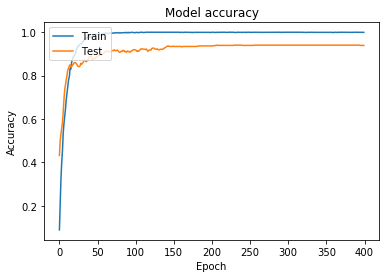

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## With frame_sampling

In [26]:
lr = 5e-6
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [27]:
epochs = 50
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    #for i in range(len(Train['pose'])): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
        p = sampling_frame(p,C)
       
        #rotation
        x_angle = np.random.uniform(-0.2,0.2)
        y_angle = np.random.uniform(-0.2,0.2)
        z_angle = np.random.uniform(-0.2,0.2)
        R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
        p = rotaion_one(p,R)
         
        p[:,:,0] = p[:,:,0]*random.uniform(0.9, 1.1)+p[:,:,0]*random.uniform(-0.1,0.1)
        p[:,:,1] = p[:,:,1]*random.uniform(0.9, 1.1)+p[:,:,1]*random.uniform(-0.1,0.1)
        p[:,:,2] = p[:,:,2]*random.uniform(0.9, 1.1)+p[:,:,2]*random.uniform(-0.1,0.1)
     
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    AR_single.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

    if e%10==0:
        AR_single.save_weights('weights/coarse_1D_heavy_aug.h5')
        


  1%|          | 13/1960 [00:00<00:15, 127.40it/s]

epoch0


/home/fan/anaconda3/envs/keras/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 1960/1960 [00:06<00:00, 289.34it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 6s 3ms/step - loss: 0.0540 - acc: 0.9918 - val_loss: 0.3109 - val_acc: 0.9274


  1%|          | 18/1960 [00:00<00:11, 176.54it/s]

epoch1


100%|██████████| 1960/1960 [00:06<00:00, 291.79it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 94us/step - loss: 0.0632 - acc: 0.9893 - val_loss: 0.3111 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch2


100%|██████████| 1960/1960 [00:07<00:00, 275.68it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 88us/step - loss: 0.0516 - acc: 0.9888 - val_loss: 0.3113 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch3


100%|██████████| 1960/1960 [00:06<00:00, 300.21it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 81us/step - loss: 0.0568 - acc: 0.9898 - val_loss: 0.3113 - val_acc: 0.9286


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch4


100%|██████████| 1960/1960 [00:06<00:00, 298.07it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 72us/step - loss: 0.0507 - acc: 0.9913 - val_loss: 0.3112 - val_acc: 0.9298


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch5


100%|██████████| 1960/1960 [00:06<00:00, 298.81it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0590 - acc: 0.9878 - val_loss: 0.3114 - val_acc: 0.9298


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch6


100%|██████████| 1960/1960 [00:06<00:00, 298.28it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0577 - acc: 0.9888 - val_loss: 0.3115 - val_acc: 0.9298


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch7


100%|██████████| 1960/1960 [00:06<00:00, 300.92it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 85us/step - loss: 0.0647 - acc: 0.9888 - val_loss: 0.3118 - val_acc: 0.9298


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch8


100%|██████████| 1960/1960 [00:06<00:00, 303.42it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 67us/step - loss: 0.0513 - acc: 0.9908 - val_loss: 0.3122 - val_acc: 0.9298


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch9


100%|██████████| 1960/1960 [00:06<00:00, 311.10it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 74us/step - loss: 0.0601 - acc: 0.9913 - val_loss: 0.3125 - val_acc: 0.9298


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch10


100%|██████████| 1960/1960 [00:06<00:00, 297.22it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 66us/step - loss: 0.0576 - acc: 0.9878 - val_loss: 0.3129 - val_acc: 0.9286


  1%|          | 18/1960 [00:00<00:11, 175.13it/s]

epoch11


100%|██████████| 1960/1960 [00:06<00:00, 300.69it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 65us/step - loss: 0.0460 - acc: 0.9923 - val_loss: 0.3132 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch12


100%|██████████| 1960/1960 [00:06<00:00, 298.66it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 65us/step - loss: 0.0584 - acc: 0.9888 - val_loss: 0.3135 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch13


100%|██████████| 1960/1960 [00:06<00:00, 299.66it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 79us/step - loss: 0.0615 - acc: 0.9878 - val_loss: 0.3138 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch14


100%|██████████| 1960/1960 [00:06<00:00, 298.52it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 69us/step - loss: 0.0489 - acc: 0.9908 - val_loss: 0.3140 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch15


100%|██████████| 1960/1960 [00:06<00:00, 294.98it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 65us/step - loss: 0.0556 - acc: 0.9888 - val_loss: 0.3142 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch16


100%|██████████| 1960/1960 [00:06<00:00, 296.69it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 71us/step - loss: 0.0546 - acc: 0.9913 - val_loss: 0.3145 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch17


100%|██████████| 1960/1960 [00:06<00:00, 298.20it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0442 - acc: 0.9939 - val_loss: 0.3146 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch18


100%|██████████| 1960/1960 [00:06<00:00, 290.28it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 65us/step - loss: 0.0567 - acc: 0.9872 - val_loss: 0.3147 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch19


100%|██████████| 1960/1960 [00:06<00:00, 311.45it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0606 - acc: 0.9878 - val_loss: 0.3149 - val_acc: 0.9274


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch20


100%|██████████| 1960/1960 [00:06<00:00, 315.86it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 78us/step - loss: 0.0582 - acc: 0.9898 - val_loss: 0.3152 - val_acc: 0.9274


  1%|          | 18/1960 [00:00<00:11, 176.16it/s]

epoch21


100%|██████████| 1960/1960 [00:06<00:00, 307.57it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 69us/step - loss: 0.0484 - acc: 0.9923 - val_loss: 0.3155 - val_acc: 0.9262


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch22


100%|██████████| 1960/1960 [00:06<00:00, 310.24it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 67us/step - loss: 0.0518 - acc: 0.9913 - val_loss: 0.3157 - val_acc: 0.9262


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch23


100%|██████████| 1960/1960 [00:06<00:00, 311.19it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0489 - acc: 0.9949 - val_loss: 0.3160 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch24


100%|██████████| 1960/1960 [00:06<00:00, 315.88it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 75us/step - loss: 0.0475 - acc: 0.9918 - val_loss: 0.3163 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch25


100%|██████████| 1960/1960 [00:06<00:00, 310.60it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0538 - acc: 0.9908 - val_loss: 0.3166 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch26


100%|██████████| 1960/1960 [00:06<00:00, 309.23it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0479 - acc: 0.9918 - val_loss: 0.3169 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch27


100%|██████████| 1960/1960 [00:06<00:00, 306.90it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 65us/step - loss: 0.0456 - acc: 0.9918 - val_loss: 0.3171 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch28


100%|██████████| 1960/1960 [00:06<00:00, 310.14it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 68us/step - loss: 0.0474 - acc: 0.9934 - val_loss: 0.3174 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch29


100%|██████████| 1960/1960 [00:06<00:00, 283.82it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 87us/step - loss: 0.0505 - acc: 0.9903 - val_loss: 0.3175 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch30


100%|██████████| 1960/1960 [00:06<00:00, 310.47it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0394 - acc: 0.9934 - val_loss: 0.3176 - val_acc: 0.9250


  1%|          | 18/1960 [00:00<00:10, 179.22it/s]

epoch31


100%|██████████| 1960/1960 [00:06<00:00, 306.20it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0560 - acc: 0.9908 - val_loss: 0.3176 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch32


100%|██████████| 1960/1960 [00:06<00:00, 302.92it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 72us/step - loss: 0.0552 - acc: 0.9883 - val_loss: 0.3177 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch33


100%|██████████| 1960/1960 [00:06<00:00, 300.61it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0458 - acc: 0.9903 - val_loss: 0.3177 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch34


100%|██████████| 1960/1960 [00:06<00:00, 294.68it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0511 - acc: 0.9929 - val_loss: 0.3178 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch35


100%|██████████| 1960/1960 [00:06<00:00, 299.03it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 69us/step - loss: 0.0552 - acc: 0.9903 - val_loss: 0.3179 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch36


100%|██████████| 1960/1960 [00:06<00:00, 295.01it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 91us/step - loss: 0.0424 - acc: 0.9923 - val_loss: 0.3179 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch37


100%|██████████| 1960/1960 [00:06<00:00, 305.59it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 68us/step - loss: 0.0632 - acc: 0.9862 - val_loss: 0.3180 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch38


100%|██████████| 1960/1960 [00:06<00:00, 303.31it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 66us/step - loss: 0.0448 - acc: 0.9929 - val_loss: 0.3181 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch39


100%|██████████| 1960/1960 [00:06<00:00, 303.11it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 67us/step - loss: 0.0611 - acc: 0.9872 - val_loss: 0.3181 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch40


100%|██████████| 1960/1960 [00:06<00:00, 303.32it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 72us/step - loss: 0.0540 - acc: 0.9878 - val_loss: 0.3180 - val_acc: 0.9250


  1%|          | 18/1960 [00:00<00:10, 178.21it/s]

epoch41


100%|██████████| 1960/1960 [00:06<00:00, 311.83it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0634 - acc: 0.9883 - val_loss: 0.3179 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch42


100%|██████████| 1960/1960 [00:06<00:00, 312.59it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 68us/step - loss: 0.0631 - acc: 0.9898 - val_loss: 0.3179 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch43


100%|██████████| 1960/1960 [00:06<00:00, 305.26it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 69us/step - loss: 0.0502 - acc: 0.9888 - val_loss: 0.3179 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch44


100%|██████████| 1960/1960 [00:06<00:00, 312.68it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 66us/step - loss: 0.0450 - acc: 0.9908 - val_loss: 0.3178 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch45


100%|██████████| 1960/1960 [00:06<00:00, 313.84it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 81us/step - loss: 0.0544 - acc: 0.9878 - val_loss: 0.3177 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch46


100%|██████████| 1960/1960 [00:06<00:00, 314.16it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0385 - acc: 0.9944 - val_loss: 0.3175 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch47


100%|██████████| 1960/1960 [00:06<00:00, 294.64it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0479 - acc: 0.9929 - val_loss: 0.3175 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch48


100%|██████████| 1960/1960 [00:06<00:00, 288.64it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 71us/step - loss: 0.0562 - acc: 0.9908 - val_loss: 0.3174 - val_acc: 0.9250


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch49


100%|██████████| 1960/1960 [00:06<00:00, 299.82it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 67us/step - loss: 0.0488 - acc: 0.9929 - val_loss: 0.3173 - val_acc: 0.9250


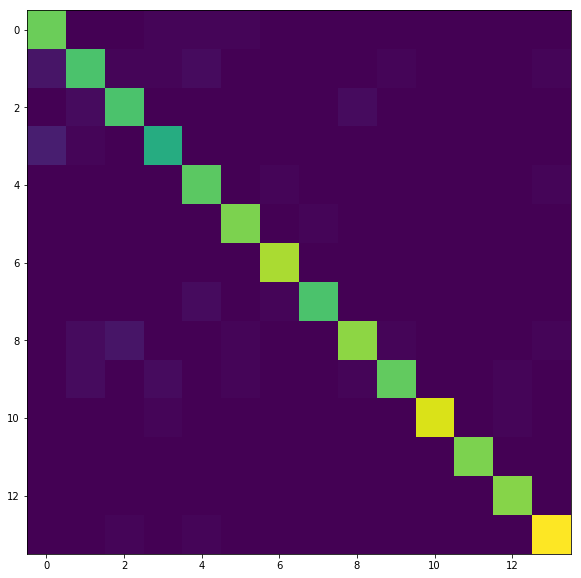

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = AR_single.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()